In [3]:
import pandas as pd
import numpy as np
from dotenv import dotenv_values, find_dotenv
import os
from datacleaning.functions import filter_by_granularity
from statsmodels.tsa.api import VAR
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
config = dotenv_values(find_dotenv())
path_rawdata = os.path.abspath(config["RAWDATA"]) + '\\'
path_cleandata = os.path.abspath(config["CLEANDATA"]) + '\\'
path_figures = os.path.abspath(config["FIGURES"]) + '\\'
bea = pd.read_pickle(path_cleandata + '//BEA_PCE.pkl')

Replicating Shipiro Exactly

In [4]:
bea = pd.read_pickle(path_cleandata + '//BEA_PCE.pkl')
total_dates = bea['date'].nunique() 
product_dates_count = bea.dropna().groupby('product')['date'].nunique()
products_appear_all_dates = product_dates_count[product_dates_count == total_dates].index.tolist()
products_to_include = list(set(products_appear_all_dates))
products_to_include.sort()

lags = 8
residuals_real = pd.DataFrame(columns=['date', 'product', 'resid_price', 'resid_quantity'])

for product in products_to_include:
    # filter for product
    original = bea[bea['product'] == product][['date', 'priceindex', 'quantityindex']].sort_values(['date'])

    # datetimeindex
    original = original.set_index('date')

    # using first differences
    original['priceindex'] = np.log(original['priceindex']).diff()
    original['quantityindex'] = np.log(original['quantityindex']).diff()

    # drop nans for model
    original.dropna(inplace=True)

    # fit
    model_original = VAR(original.asfreq('Q-OCT'))
    result_original = model_original.fit(lags)

    # residuals
    residuals_original = result_original.resid.reset_index()
    residuals_original['product'] = product
    residuals_original.rename(columns={'priceindex': 'resid_price', 'quantityindex': 'resid_quantity'}, inplace=True)
    residuals_real = pd.merge(left=residuals_real, right=residuals_original, on=['date', 'product', 'resid_price', 'resid_quantity'], how='outer')
residuals_real

C:\Users\TonyGui\AppData\Local\Temp\ipykernel_19476\1595977740.py:26: FutureWarning: 'Q-OCT' is deprecated and will be removed in a future version, please use 'QE-OCT' instead.
  model_original = VAR(original.asfreq('Q-OCT'))
C:\Users\TonyGui\AppData\Local\Temp\ipykernel_19476\1595977740.py:26: FutureWarning: 'Q-OCT' is deprecated and will be removed in a future version, please use 'QE-OCT' instead.
  model_original = VAR(original.asfreq('Q-OCT'))
C:\Users\TonyGui\AppData\Local\Temp\ipykernel_19476\1595977740.py:26: FutureWarning: 'Q-OCT' is deprecated and will be removed in a future version, please use 'QE-OCT' instead.
  model_original = VAR(original.asfreq('Q-OCT'))
C:\Users\TonyGui\AppData\Local\Temp\ipykernel_19476\1595977740.py:26: FutureWarning: 'Q-OCT' is deprecated and will be removed in a future version, please use 'QE-OCT' instead.
  model_original = VAR(original.asfreq('Q-OCT'))
C:\Users\TonyGui\AppData\Local\Temp\ipykernel_19476\1595977740.py:26: FutureWarning: 'Q-OCT' is 

,date,product,resid_price,resid_quantity
0,1961-04-30,Accessories and parts,0.004256,0.014899
1,1961-04-30,Accommodations,-0.005484,0.002631
2,1961-04-30,Accounting and other business services,-0.001260,-0.003424
3,1961-04-30,Admissions to specified spectator amusements,-0.000510,-0.028992
4,1961-04-30,Air transportation,0.014324,0.038847
...,...,...,...,...
75245,2023-07-31,Water transportation,0.020567,-0.010366
75246,2023-07-31,Window coverings,0.015643,-0.022738
75247,2023-07-31,Wine,-0.004331,-0.001757
75248,2023-07-31,Women's and girls' clothing,-0.002967,0.007265


In [39]:
bea["product"]
unique_values = bea["product"].unique()
len(products_appear_all_dates)
product_dates_count

difference = list(set(unique_values) - set(products_appear_all_dates))
print(len(unique_values))
len(products_appear_all_dates)


344


301

In [19]:
# supply vs demand driven
residuals_real['majority_demand'] = ((residuals_real['resid_price'] * residuals_real['resid_quantity']) >= 0).astype(int)
residuals_real['majority_supply'] = ((residuals_real['resid_price'] * residuals_real['resid_quantity']) < 0).astype(int)

bea = pd.read_pickle(path_cleandata + '//BEA_PCE.pkl')
bea = bea.sort_values(by=['product', 'date'])
bea = bea.reset_index(drop=True)

# Finds Infation for each Product
def annual_inflation_calculator(df):
    df = df.sort_index()
    df['inflation'] = (df['priceindex'] / df['priceindex'].shift(4) - 1) * 100
    return df

bea = bea.groupby('product').apply(annual_inflation_calculator).reset_index(drop=True)
bea['sum expenditures'] = bea.groupby('date')['expenditures'].transform('sum')

data = bea.merge(residuals_real, on=['date', 'product'], how='inner')
data = data.sort_values(by=['product', 'date'])

data_graph = data[["product", "date", "expenditures", "sum expenditures" , "inflation", "majority_demand", "majority_supply"]]

data_graph["alpha"] = data_graph["expenditures"]/data_graph["sum expenditures"]
data_graph["weighted inflation"] = data_graph["alpha"] * data_graph["inflation"]

demand = data_graph[data_graph['majority_demand'] == 1]
demand_data = demand.groupby('date')['weighted inflation'].sum().reset_index()
# demand_data.to_excel("demand.xlsx")
supply = data_graph[data_graph['majority_demand'] == 0]
supply_data = supply.groupby('date')['weighted inflation'].sum().reset_index()

plot_data = pd.merge(demand_data, supply_data, on='date', suffixes=('_demand', '_supply'))

# condition = (plot_data['date'] == '1970-01-31')

# index_want = plot_data[condition].index

plot_data = plot_data.iloc[31:, :]
plot_data

plot_data['demand_pos'] = plot_data['weighted inflation_demand'].apply(lambda x: x if x > 0 else 0)
plot_data['supply_pos'] = plot_data['weighted inflation_supply'].apply(lambda x: x if x > 0 else 0)
plot_data['supply_neg'] = plot_data['weighted inflation_supply'].apply(lambda x: x if x < 0 else 0)
plot_data['demand_neg'] = plot_data['weighted inflation_demand'].apply(lambda x: x if x < 0 else 0)
# plot_data.to_excel("plotdata.xlsx")


C:\Users\TonyGui\AppData\Local\Temp\ipykernel_19476\4260578962.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bea = bea.groupby('product').apply(annual_inflation_calculator).reset_index(drop=True)
C:\Users\TonyGui\AppData\Local\Temp\ipykernel_19476\4260578962.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_graph["alpha"] = data_graph["expenditures"]/data_graph["sum expenditures"]
C:\Users\TonyGui\AppData\Local\Temp\ipykernel_19476\4260578962

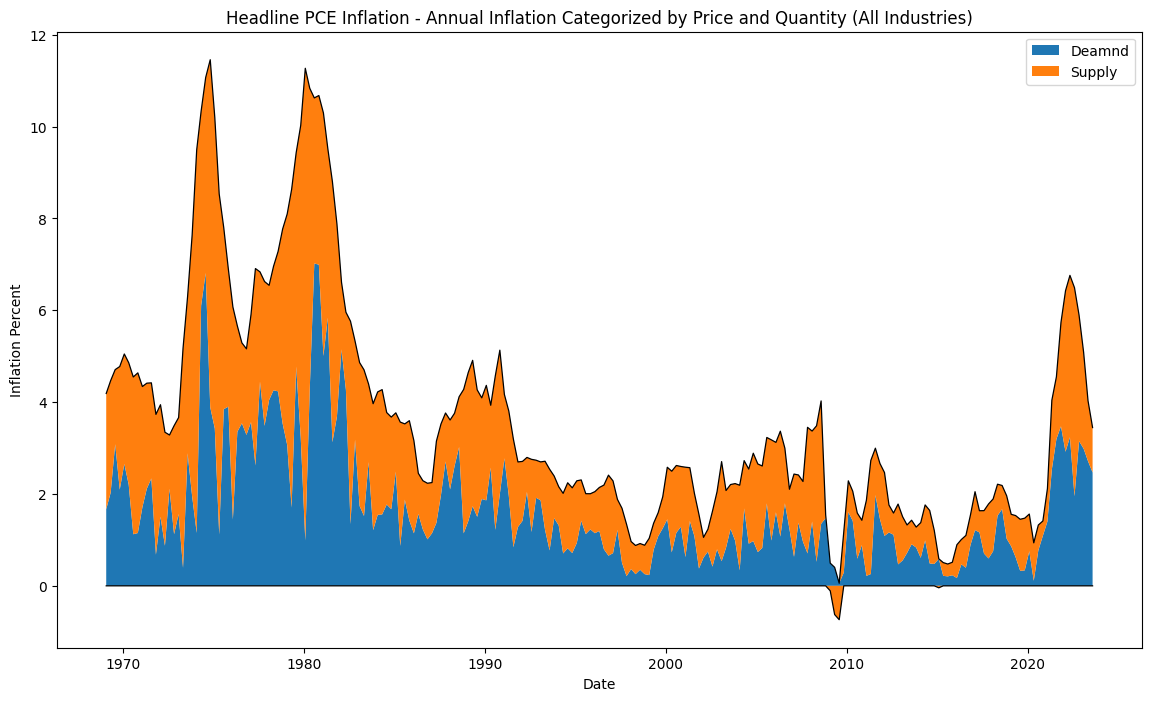

In [245]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.stackplot(plot_data['date'],plot_data['demand_pos'], plot_data['supply_pos'], colors= ["#1f77b4", "#ff7f0e"], labels = ["Deamnd", "Supply"])
plt.stackplot(plot_data['date'],plot_data['demand_neg'], plot_data['supply_neg'], colors= ["#1f77b4", "#ff7f0e"])
plt.xlabel('Date')
plt.ylabel('Inflation Percent')
plt.title('Headline PCE Inflation - Annual Inflation Categorized by Price and Quantity (All Industries)')
plt.legend()

top_values = plot_data['demand_pos']
top_values += plot_data['supply_pos']
ax.plot(plot_data['date'], top_values, color='black', linewidth=0.9)

bottom = plot_data['demand_neg']
bottom += plot_data['supply_neg']
ax.plot(plot_data['date'], bottom, color='black', linewidth=0.9)

plt.show()

Replicating Shipiro with Sales and VA

In [246]:
residuals_all = pd.read_pickle(path_cleandata + 'inversions//residuals.pkl')
# classifications
residuals_all['majority_demand'] = ((residuals_all['resid_price'] * residuals_all['resid_quantity']) >= 0).astype(int)
residuals_all['majority_supply'] = ((residuals_all['resid_price'] * residuals_all['resid_quantity']) < 0).astype(int)
# supply vs demand driven
residuals_all['majority_demand_a'] = ((residuals_all['resid_valueadded'] * residuals_all['resid_sales']) >= 0).astype(int)
residuals_all['majority_supply_a'] = ((residuals_all['resid_valueadded'] * residuals_all['resid_sales']) < 0).astype(int)

bea = pd.read_pickle(path_cleandata + '//BEA_PCE.pkl')
bea = bea.sort_values(by=['product', 'date'])
bea = bea.reset_index(drop=True)

# Finds Infation for each Product

def annual_inflation_calculator(df):
    # Ensure the group is sorted by index if necessary
    df = df.sort_index()
    # Calculate the new values
    df['inflation'] = (df['priceindex'] / df['priceindex'].shift(4) - 1) * 100
    return df
residuals_all
bea = bea.groupby('product').apply(annual_inflation_calculator).reset_index(drop=True)

bea['sum expenditures'] = bea.groupby('date')['expenditures'].transform('sum')

data_all = bea.merge(residuals_all, on=['date', 'product'], how='inner')
data_all = data_all.sort_values(by=['product', 'date'])

data_graph_all = data_all[["product", "date", "expenditures", "sum expenditures" , "inflation", "majority_demand", "majority_supply", "majority_demand_a", "majority_supply_a"]]

data_graph_all["alpha"] = data_graph_all["expenditures"]/data_graph_all["sum expenditures"]
data_graph_all["weighted inflation"] = data_graph_all["alpha"] * data_graph_all["inflation"]

demand_all = data_graph_all[data_graph_all['majority_demand_a'] == 1]
demand_data_all = demand_all.groupby('date')['weighted inflation'].sum().reset_index()

supply_all = data_graph_all[data_graph_all['majority_demand_a'] == 0]
supply_data_all = supply_all.groupby('date')['weighted inflation'].sum().reset_index()
plot_data_all = pd.merge(demand_data_all, supply_data_all, on='date', suffixes=('_demand', '_supply'))
plot_data_all
condition = (plot_data['date'] == '1970-01-31')

# index_want = plot_data_all[condition].index

plot_data_all = plot_data_all.iloc[35:, :]
plot_data_all

plot_data_all['demand_pos'] = plot_data_all['weighted inflation_demand'].apply(lambda x: x if x > 0 else 0)
plot_data_all['supply_pos'] = plot_data_all['weighted inflation_supply'].apply(lambda x: x if x > 0 else 0)
plot_data_all['supply_neg'] = plot_data_all['weighted inflation_supply'].apply(lambda x: x if x < 0 else 0)
plot_data_all['demand_neg'] = plot_data_all['weighted inflation_demand'].apply(lambda x: x if x < 0 else 0)
plot_data_all['sum'] = plot_data_all['weighted inflation_demand'] + plot_data_all['weighted inflation_supply']


C:\Users\TonyGui\AppData\Local\Temp\ipykernel_13216\3856130513.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bea = bea.groupby('product').apply(annual_inflation_calculator).reset_index(drop=True)
C:\Users\TonyGui\AppData\Local\Temp\ipykernel_13216\3856130513.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_graph_all["alpha"] = data_graph_all["expenditures"]/data_graph_all["sum expenditures"]
C:\Users\TonyGui\AppData\Local\Temp\ipykernel_1321

,date,weighted inflation_demand,weighted inflation_supply,demand_pos,supply_pos,supply_neg,demand_neg,sum
190,2008-10-31,-0.116473,0.218653,0.000000,0.218653,0.000000,-0.116473,0.102180
191,2009-01-31,-0.171971,0.141586,0.000000,0.141586,0.000000,-0.171971,-0.030385
192,2009-04-30,-0.139323,0.016618,0.000000,0.016618,0.000000,-0.139323,-0.122704
193,2009-07-31,-0.136022,-0.046444,0.000000,0.000000,-0.046444,-0.136022,-0.182467
194,2009-10-31,-0.040301,0.092994,0.000000,0.092994,0.000000,-0.040301,0.052693
195,2010-01-31,0.210834,0.032651,0.210834,0.032651,0.000000,0.000000,0.243484
196,2010-04-30,0.185846,0.030051,0.185846,0.030051,0.000000,0.000000,0.215898
197,2010-07-31,0.104746,0.045787,0.104746,0.045787,0.000000,0.000000,0.150532
198,2010-10-31,0.083376,0.049959,0.083376,0.049959,0.000000,0.000000,0.133335
199,2011-01-31,0.154766,0.035735,0.154766,0.035735,0.000000,0.000000,0.190501


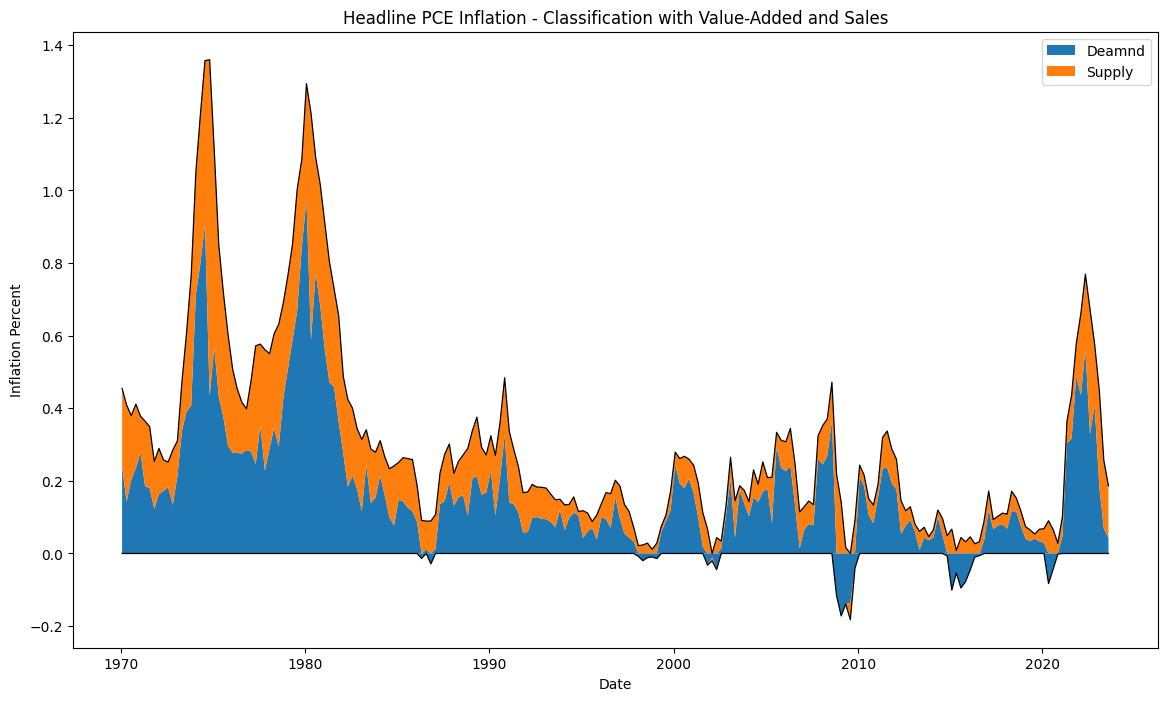

In [247]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.stackplot(plot_data_all['date'],plot_data_all['demand_pos'], plot_data_all['supply_pos'], colors= ["#1f77b4", "#ff7f0e"], labels = ["Deamnd", "Supply"])
plt.stackplot(plot_data_all['date'],plot_data_all['demand_neg'], plot_data_all['supply_neg'], colors= ["#1f77b4", "#ff7f0e"])
plt.xlabel('Date')
plt.ylabel('Inflation Percent')
plt.title('Headline PCE Inflation - Classification with Value-Added and Sales')
plt.legend()

top_values_all = plot_data_all['demand_pos']
top_values_all += plot_data_all['supply_pos']
ax.plot(plot_data_all['date'], top_values_all, color='black', linewidth=0.9)

bottom_all = plot_data_all['demand_neg']
bottom_all += plot_data_all['supply_neg']

ax.plot(plot_data_all['date'], bottom_all, color='black', linewidth=0.9)
plt.show()

Classification with Price and Quantity but with IO Industries

In [ ]:
residuals_all = pd.read_pickle(path_cleandata + 'inversions//residuals.pkl')
# classifications
residuals_all['majority_demand'] = ((residuals_all['resid_price'] * residuals_all['resid_quantity']) >= 0).astype(int)
residuals_all['majority_supply'] = ((residuals_all['resid_price'] * residuals_all['resid_quantity']) < 0).astype(int)
# supply vs demand driven
residuals_all['majority_demand_a'] = ((residuals_all['resid_valueadded'] * residuals_all['resid_sales']) >= 0).astype(int)
residuals_all['majority_supply_a'] = ((residuals_all['resid_valueadded'] * residuals_all['resid_sales']) < 0).astype(int)

bea = pd.read_pickle(path_cleandata + '//BEA_PCE.pkl')
bea = bea.sort_values(by=['product', 'date'])
bea = bea.reset_index(drop=True)

# Finds Infation for each Product
def annual_inflation_calculator(df):
    df = df.sort_index()
    df['inflation'] = (df['priceindex'] / df['priceindex'].shift(4) - 1) * 100
    return df

bea = bea.groupby('product').apply(annual_inflation_calculator).reset_index(drop=True)
bea['sum expenditures'] = bea.groupby('date')['expenditures'].transform('sum')
data_all = bea.merge(residuals_all, on=['date', 'product'], how='inner')
data_all = data_all.sort_values(by=['product', 'date'])

data_graph_all = data_all[["product", "date", "expenditures", "sum expenditures" , "inflation", "majority_demand", "majority_supply", "majority_demand_a", "majority_supply_a"]]

data_graph_all["alpha"] = data_graph_all["expenditures"]/data_graph_all["sum expenditures"]
data_graph_all["weighted inflation"] = data_graph_all["alpha"] * data_graph_all["inflation"]

demand_all = data_graph_all[data_graph_all['majority_demand'] == 1]
demand_data_all = demand_all.groupby('date')['weighted inflation'].sum().reset_index()

supply_all = data_graph_all[data_graph_all['majority_demand'] == 0]
supply_data_all = supply_all.groupby('date')['weighted inflation'].sum().reset_index()
plot_data_all = pd.merge(demand_data_all, supply_data_all, on='date', suffixes=('_demand', '_supply'))
plot_data_all
condition = (plot_data['date'] == '1970-01-31')

# index_want = plot_data_all[condition].index

plot_data_all = plot_data_all.iloc[35:, :]
plot_data_all

plot_data_all['demand_pos'] = plot_data_all['weighted inflation_demand'].apply(lambda x: x if x > 0 else 0)
plot_data_all['supply_pos'] = plot_data_all['weighted inflation_supply'].apply(lambda x: x if x > 0 else 0)
plot_data_all['supply_neg'] = plot_data_all['weighted inflation_supply'].apply(lambda x: x if x < 0 else 0)
plot_data_all['demand_neg'] = plot_data_all['weighted inflation_demand'].apply(lambda x: x if x < 0 else 0)
plot_data_all['sum'] = plot_data_all['weighted inflation_demand'] + plot_data_all['weighted inflation_supply']
plot_data_all.tail(60)

C:\Users\TonyGui\AppData\Local\Temp\ipykernel_13216\2370225231.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bea = bea.groupby('product').apply(annual_inflation_calculator).reset_index(drop=True)
C:\Users\TonyGui\AppData\Local\Temp\ipykernel_13216\2370225231.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_graph_all["alpha"] = data_graph_all["expenditures"]/data_graph_all["sum expenditures"]
C:\Users\TonyGui\AppData\Local\Temp\ipykernel_1321

,date,weighted inflation_demand,weighted inflation_supply,demand_pos,supply_pos,supply_neg,demand_neg,sum
190,2008-10-31,0.069364,0.032815,0.069364,0.032815,0.000000,0.000000,0.102180
191,2009-01-31,-0.054744,0.024359,0.000000,0.024359,0.000000,-0.054744,-0.030385
192,2009-04-30,0.061526,-0.184231,0.061526,0.000000,-0.184231,0.000000,-0.122704
193,2009-07-31,0.013997,-0.196463,0.013997,0.000000,-0.196463,0.000000,-0.182467
194,2009-10-31,0.058418,-0.005725,0.058418,0.000000,-0.005725,0.000000,0.052693
195,2010-01-31,0.189063,0.054422,0.189063,0.054422,0.000000,0.000000,0.243484
196,2010-04-30,0.149725,0.066173,0.149725,0.066173,0.000000,0.000000,0.215898
197,2010-07-31,0.062719,0.087814,0.062719,0.087814,0.000000,0.000000,0.150532
198,2010-10-31,0.040721,0.092614,0.040721,0.092614,0.000000,0.000000,0.133335
199,2011-01-31,0.043211,0.147289,0.043211,0.147289,0.000000,0.000000,0.190501


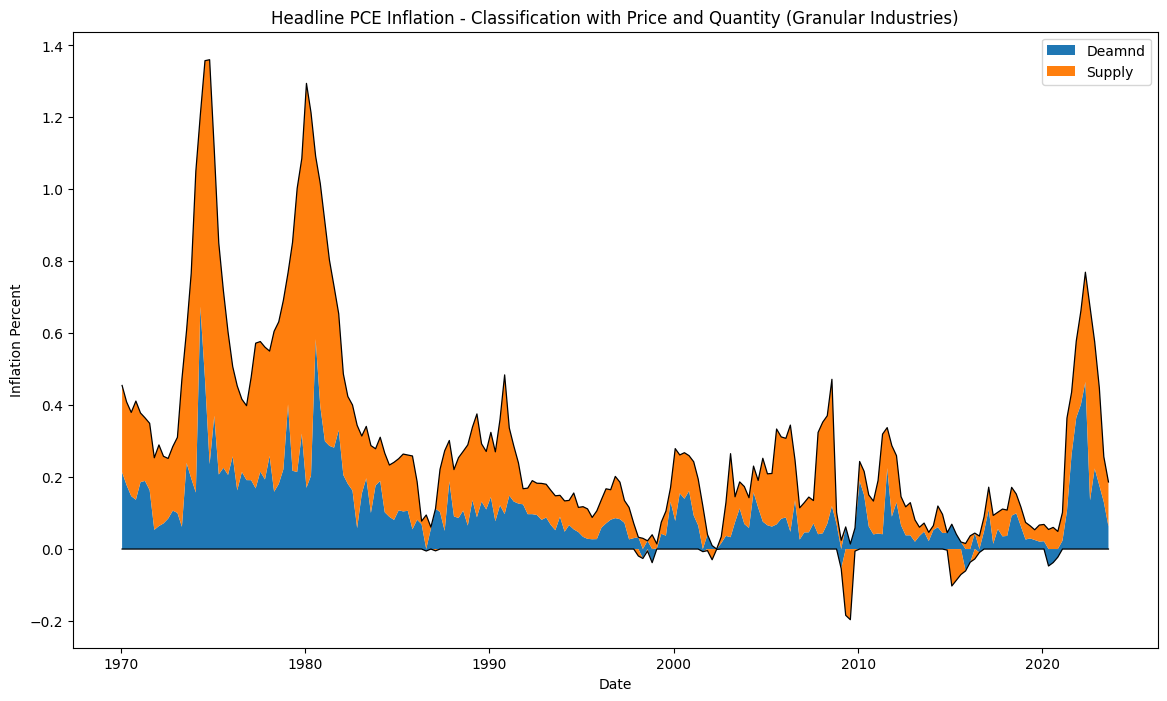

In [249]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.stackplot(plot_data_all['date'],plot_data_all['demand_pos'], plot_data_all['supply_pos'], colors= ["#1f77b4", "#ff7f0e"], labels = ["Deamnd", "Supply"])
plt.stackplot(plot_data_all['date'],plot_data_all['demand_neg'], plot_data_all['supply_neg'], colors= ["#1f77b4", "#ff7f0e"])
plt.xlabel('Date')
plt.ylabel('Inflation Percent')
plt.title('Headline PCE Inflation - Classification with Price and Quantity (Granular Industries)')
plt.legend()

top_values_all_1 = plot_data_all['demand_pos']
top_values_all_1 += plot_data_all['supply_pos']
ax.plot(plot_data_all['date'], top_values_all_1, color='black', linewidth=0.9)

bottom_all_1 = plot_data_all['demand_neg']
bottom_all_1 += plot_data_all['supply_neg']

ax.plot(plot_data_all['date'], bottom_all_1, color='black', linewidth=0.9)
plt.show()